<hr>
<font size=5 color='#3E54D3'> <b> Football Player Segmentation - K. Weigel </b> </font>
<hr/>


Semantic Segmentation is a computer vision task in which the goal is to categorize each pixel in an image into a class or object. The goal is to produce a dense pixel-wise segmentation map of an image, where each pixel is assigned to a specific class or object. In this project we will use [Football Player Dataset](https://www.kaggle.com/datasets/ihelon/football-player-segmentation?select=images), and build a deep learning model that performs semantic segmentation. There are 512 images in the set, together with JSON file containing image information.


## 1 - Packages

In [1]:
import os
import numpy as np
import json
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## 2 - Preparing the data

In [2]:
zip_ref = zipfile.ZipFile('/content/drive/My Drive/football-players-segmentation/football-players.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
INPUT_SIZE = (1920, 1080)
IMG_SIZE = 512 # image size for the network
N = 512
path = ''
image_path = os.path.join(path, '/content/images/')
mask_path = os.path.join(path, '/content/annotations/')
with open("/content/annotations/instances_default.json") as f:
    annotations = json.load(f)

### 2.1 - Loading images
We will first load and resize the images. The original resolution of the images is 1920 x 1080, we will resize them to 512 x 512 for faster and more efficient training.

In [4]:
image_id_dict = {image['id']: image['file_name'] for image in annotations['images']}

In [5]:
images = np.zeros((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
for img_id, img_filename in image_id_dict.items():
    img = Image.open(os.path.join(image_path, img_filename))
    img = img.resize((IMG_SIZE, IMG_SIZE))
    images[img_id - 1] = img

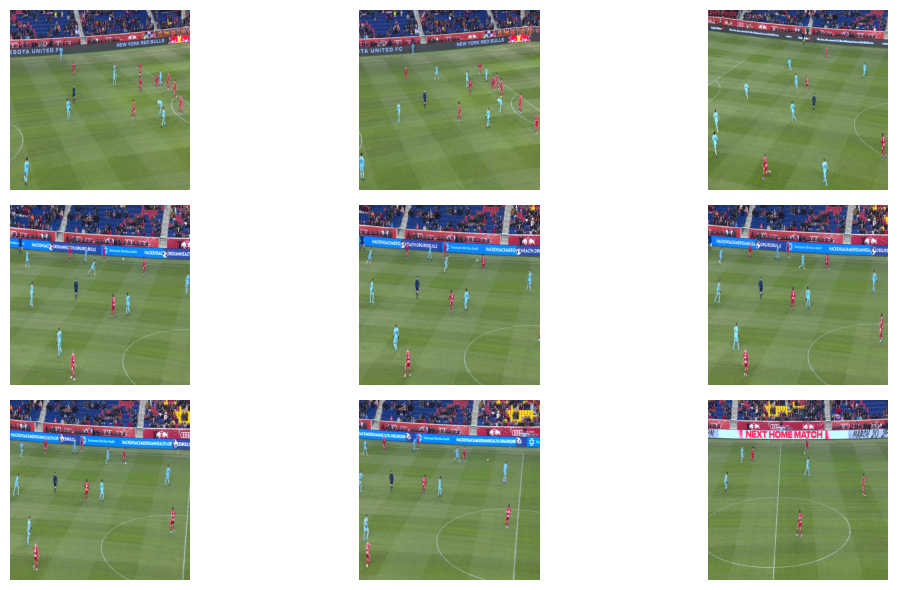

In [6]:
# show first 9 images
fig = plt.figure(figsize=(12, 6))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i]/255)
    plt.axis('off')

fig.tight_layout()

### 2.2 - Loading masks
The segmentation masks are stored in a JSON file, where each segmentation is represented by a list of coordinates $[x_0, y_0, x_1, y_1, \dots, x_k, y_k]$. We use `pillow` for making the masks. We begin by initializing a new black image, and then use the spatial information to draw the 'player polygon'.

1


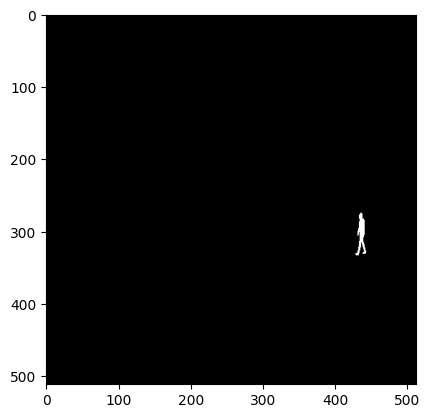

In [7]:
# Example of one annotation mask
annote = annotations['annotations'][0]
print(annote['image_id'])
mask = Image.new('1', INPUT_SIZE) # create new image in INPUT_SIZE filled with black (default)
mask_draw = ImageDraw.Draw(mask, '1') # so we can draw on the mask image
mask_draw.polygon(annote['segmentation'][0], fill=1) # draw a player in white
mask = mask.resize((IMG_SIZE, IMG_SIZE))
plt.imshow(mask)

In [8]:
masks = np.zeros((N, IMG_SIZE, IMG_SIZE), dtype=bool)

# iterate through all annotations
for annotation in annotations['annotations']:
    # get image id of the annotation
    img_id = annotation['image_id']
    mask = Image.new('1', INPUT_SIZE)
    mask_draw = ImageDraw.ImageDraw(mask, '1')
    segmentation = annotation['segmentation'][0]
    mask_draw.polygon(segmentation, fill=1)
    bool_array = np.array(mask.resize((IMG_SIZE, IMG_SIZE))) > 0
    masks[img_id - 1] = masks[img_id - 1] | bool_array

In [9]:
masks = masks.reshape(N, IMG_SIZE, IMG_SIZE, 1) # add channel dimension

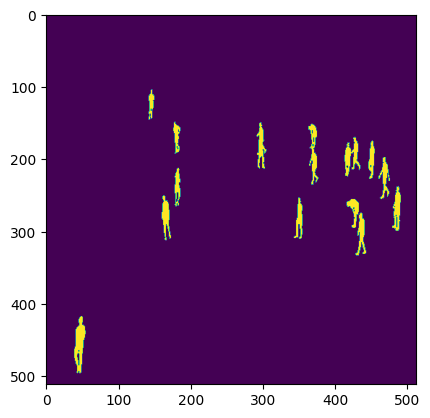

In [10]:
plt.imshow(masks[0])

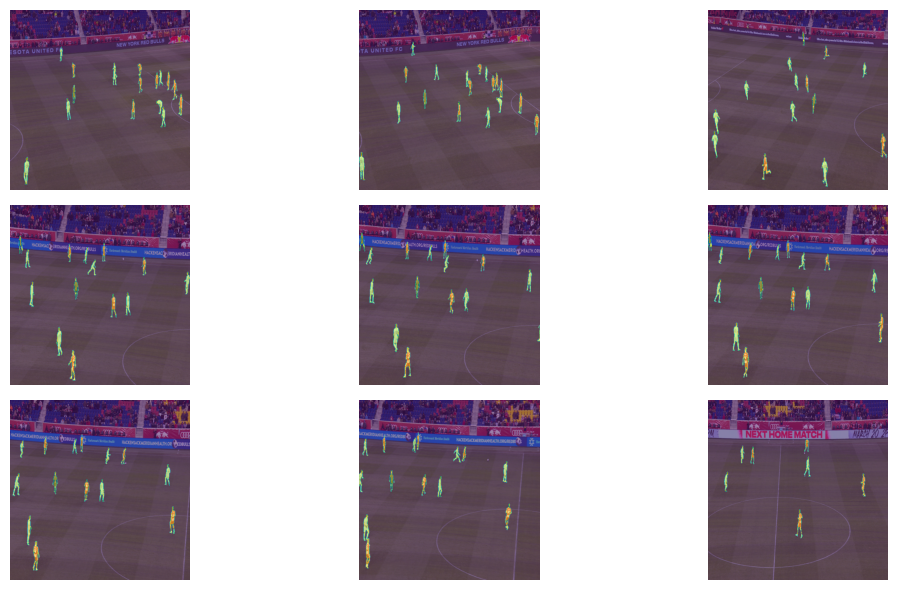

In [11]:
# masks applied on top of the images
fig = plt.figure(figsize=(12, 6))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i]/255)
    plt.imshow(masks[i], alpha=0.5)
    plt.axis('off')

fig.tight_layout()

### 2.3 - Train test split


In [12]:
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.1, random_state=42)

In [13]:
print(f"Train images shape: {images_train.shape}, Train masks shape: {masks_train.shape}")
print(f"Test images shape: {images_test.shape}, Test masks shape: {masks_test.shape}")

Train images shape: (460, 512, 512, 3), Train masks shape: (460, 512, 512, 1)
Test images shape: (52, 512, 512, 3), Test masks shape: (52, 512, 512, 1)


## 3 - U-Net

U-Net, named for its U-shape, was originally created in 2015 by Olaf Ronneberger, Philipp Fischer, and Thomas Brox, and described in their paper [U-Net: Convolutional Networks for Biomedical
Image Segmentation](https://arxiv.org/abs/1505.04597). The initial goal of U-Net was to detect tumors, but in the following years it has found applications in other semantic segmentation tasks.

### 3.1 - Model details

<img src="https://drive.google.com/uc?export=view&id=1iFdJOsLAB67zwlnO32scAz9er-EeDroJ" style="width:750px;">
<caption><center> <u><b>Figure 2</u></b>: U-Net architecture <br> </center></caption>


**Contracting path** (Encoder containing downsampling steps):

Contracting path contains several convolutional blocks, which reduce the height and width, while increasing the number of channels.

It consists of the repeated application of two 3x3 convolutions, each followed by a Batch Normalization layer, a rectified linear unit (ReLU) activation and a 2x2 max pooling operation with stride 2 for downsampling. At each convolutional block the number of channels is doubled, while the spatial dimension is reduced by half.

**Expansive path** (Decoder containing upsampling steps):

In the expansive path, the image is going to be upsized to its original size, while the channels are going to be shrunk.

Each step in the expansive path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next follows a concatenation with the feature map from the corresponding block in the contracting path, and two 3 x 3 convolutions, each followed by a BatchNorm and ReLU.

**Final Layer**: At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes.

### 3.2 - Model evaluation
Here we introduce some metrics that can be used for model evaluation.

* True positive (TP) - predicted label = 1, true label = 1
* False positive (FP) - predicted label = 1, true label = 0
* True negative (TN) - predicted label = 0, true label = 0
* False negative (FN) - predicted label = 0, true label = 1

Accuracy measures the percentage of pixels the model classified correctly.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Accuracy score can provide misleading results when the class representation is small within the image (like in our case, where the players make up a significantly smaller area than the background), as the measure will be biased in mainly reporting how well we identify the negative case.

**Precision** is defined as the number of discoveries that are relevant (true positives), out of the total discoveries the model retrieved.

$$
\text{Precision} = \frac{TP}{TP + FP}.
$$

In other words precision measures how often our model is right, when it makes a discovery (label = 1). Maximizing precision results in decreasing the number of false discoveries.

**Recall** or true-positive-rate is defined as

$$
\text{Recall} = \frac{TP}{TP + FN}.
$$

Maximizing recall would result in a model making more discoveries, which in turn would mean an increase in the number of false positives.

**F1 score** is the harmonic mean of the precision and recall:

$$
F_1 = \frac{2TP}{2TP + FP + FN}
$$

**Jaccard Index**, also known as intersection over union (IoU) is used for measuring the similarity between finite sample sets. It is defined as the size of intersection divided by size of union of the union of sample sets:

$$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}.
$$

In a classification setting it measures the number of pixels common between the target and prediction masks divided by the total number of pixels present across both masks.

In [14]:
def jaccard_index(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

In [15]:
def conv_block(inputs, n_filters, maxpooling=True):
    """
    Convolution block of U-Net. Two convolutional layers, followed by Batch Norm
    and ReLU activation.

    Inputs:
        inputs - input tensor to the block
        n_filters - number of filter for the conv layers
    Returns:
        out - output from the block
        skip - input to the decoder network
    """
    x = tfl.Conv2D(filters=n_filters, kernel_size=3, padding='same')(inputs)
    x = tfl.BatchNormalization()(x)
    x = tfl.Activation('relu')(x)
    x = tfl.Conv2D(filters=n_filters, kernel_size=3, padding='same')(x)
    x = tfl.BatchNormalization()(x)
    skip = tfl.Activation('relu')(x)
    if maxpooling == True:
        out = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(skip)
    else:
        out = skip

    return out, skip

In [16]:
def upsampling_block(expansive_input, contractive_input, n_filters):
    """
    Upsampling block

    Inputs:
        expansive_input - input from the previous layer of the expansive path
        contractive_input - input from the corresponding encoder block
    """
    # upsample and perform convolution
    up = tfl.Conv2DTranspose(n_filters, kernel_size=2, strides=2, padding='same')(expansive_input)
    # concatenate the inputs on the channel axis
    input = tfl.concatenate([up, contractive_input], axis=3)
    out, _ = conv_block(input, n_filters, False)

    return out

In [17]:
def unet_model(input_size=(512, 512, 3), n_filters=64):
    """
    U-Net model

    Inputs:
        input_size - size of the input image
        n_filters - base number of filters

    Returns:
        model - U-Net model
    """
    # Contracting path
    inputs = tfl.Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8)
    # Bridge
    cblock5 = conv_block(cblock4[0], n_filters*16, maxpooling=False)

    # Expansive path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    out = tfl.Conv2D(1, 1, padding='same', activation='sigmoid')(ublock9)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    return model

In [18]:
unet = unet_model()

In [19]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [20]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[jaccard_index, 'accuracy'])
unet.fit(images_train, masks_train, epochs=10, batch_size=4, validation_split=0.2)

Epoch 1/10
92/92 [==============================] - 144s 1s/step - loss: 0.0958 - jaccard_index: 0.2108 - accuracy: 0.9890 - val_loss: 5.7534 - val_jaccard_index: 0.0218 - val_accuracy: 0.1098
Epoch 2/10
92/92 [==============================] - 101s 1s/step - loss: 0.0219 - jaccard_index: 0.4721 - accuracy: 0.9968 - val_loss: 0.0291 - val_jaccard_index: 0.3659 - val_accuracy: 0.9957
Epoch 3/10
92/92 [==============================] - 102s 1s/step - loss: 0.0131 - jaccard_index: 0.6151 - accuracy: 0.9975 - val_loss: 0.0150 - val_jaccard_index: 0.5637 - val_accuracy: 0.9971
Epoch 4/10
92/92 [==============================] - 99s 1s/step - loss: 0.0129 - jaccard_index: 0.6455 - accuracy: 0.9968 - val_loss: 0.2050 - val_jaccard_index: 0.1661 - val_accuracy: 0.9140
Epoch 5/10
92/92 [==============================] - 101s 1s/step - loss: 0.0088 - jaccard_index: 0.7295 - accuracy: 0.9976 - val_loss: 0.0106 - val_jaccard_index: 0.6834 - val_accuracy: 0.9968
Epoch 6/10
92/92 [==================

In [21]:
# save the model to avoid retraining
unet.save('/content/drive/My Drive/football-players-segmentation/unet_model.h5')

In [ ]:
# unet = tf.keras.models.load_model('/content/drive/My Drive/football-players-segmentation/unet_model.h5')

In [22]:
unet.evaluate(images_test, masks_test, batch_size=4)

13/13 [==============================] - 4s 335ms/step - loss: 0.0056 - jaccard_index: 0.8340 - accuracy: 0.9980


[0.005571848712861538, 0.8340336084365845, 0.9980444312095642]

In [23]:
predicted_mask = unet.predict(images_test, batch_size=4)

13/13 [==============================] - 4s 337ms/step


In [24]:
predicted_mask2 = (predicted_mask > 0.5).astype(np.uint8)

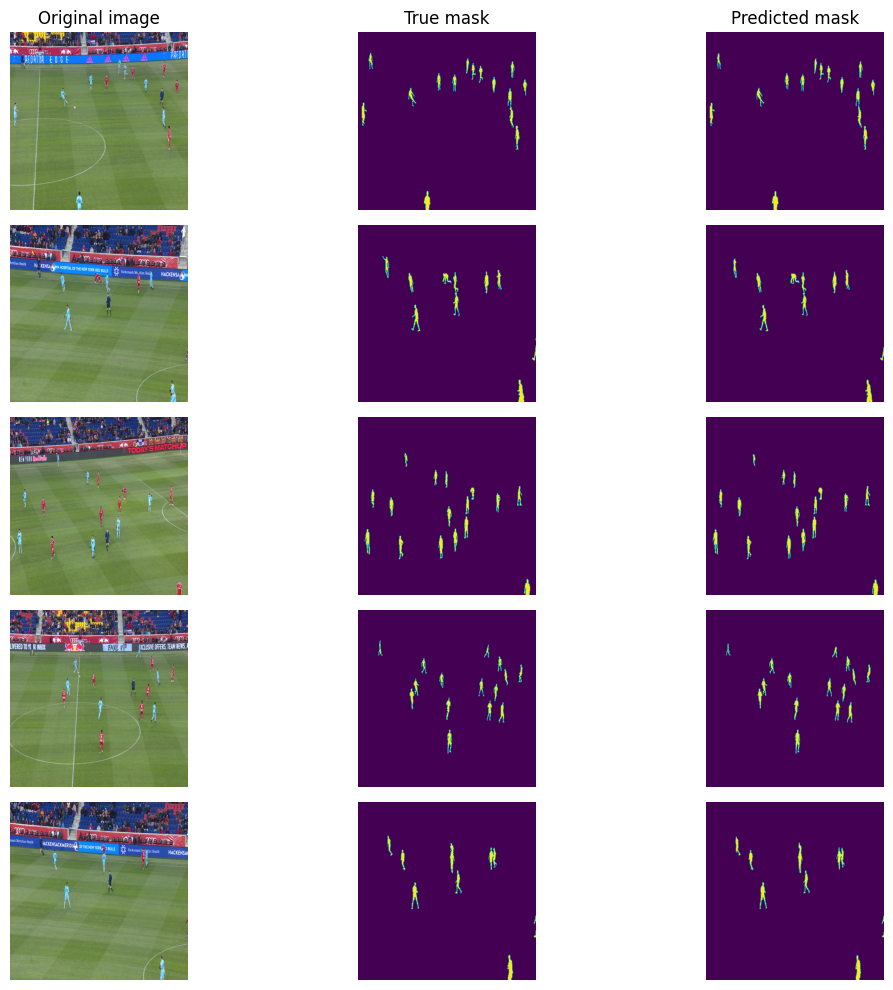

In [25]:
# predicted masks
fig, ax = plt.subplots(5, 3, figsize=(12, 10))

for i in range(5):
    ax[i, 0].imshow(images_test[i])
    ax[i, 0].axis('off')
    ax[i, 1].imshow(masks_test[i])
    ax[i, 1].axis('off')
    ax[i, 2].imshow(predicted_mask2[i])
    ax[i, 2].axis('off')

ax[0, 0].set_title('Original image')
ax[0, 1].set_title('True mask')
ax[0, 2].set_title('Predicted mask')

fig.tight_layout()

In [26]:
cr = classification_report(masks_test.flatten(), predicted_mask2.flatten())
print(cr)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00  13377023
        True       0.97      0.93      0.95    254465

    accuracy                           1.00  13631488
   macro avg       0.98      0.96      0.97  13631488
weighted avg       1.00      1.00      1.00  13631488

